In [1]:
import pandas as pd
import numpy as np
import csv
import random
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
data = pd.read_csv('user_item_playtime.csv')
data = data.sample(n=200000)
data.head(5)

,user_id,item_id,playtime_forever
957144,PsychoFire,65790,0
2196376,76561198075657638,4000,56
1337239,Nipsey,214830,0
417621,dyballs_tits,212580,46
2548745,76561198070585472,4580,0


In [10]:
len(data)

200000

In [42]:
labels = [1 if i>0 else 0 for i in data['playtime_forever']]
sum(labels)/len(labels)

0.63663

In [12]:
def splitData(X, y, p1, p2, balance=False): 
    X = np.array(X)
    y = np.array(y)

    if balance:
        total = len(y)
        n = round(len(y)*p1/2)

        idx = []
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 1:
                idx.append(i)
        X_test = X[idx]
        y_test = y[idx]
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)
        
        idx = []
        total = len(y)
        while len(idx) < n:
            i = random.choice(range(total))
            if y[i] == 0:
                idx.append(i)
        X_test = np.concatenate((X_test,X[idx]), axis=0)
        y_test = np.concatenate((y_test,y[idx]), axis=0)
        X = np.delete(X, idx, 0)
        y = np.delete(y, idx, 0)

    else:
        sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        X = X_train
        y = y_train

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    print(sum([len(y_train), len(y_valid), len(y_test)]))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

In [13]:
data_train, y_train, data_valid, y_valid, data_test, y_test = splitData(data, labels, .1, .15)

153000 27000 20000
200000


In [14]:
data_train[0]

array(['tonsils', 263840, 0], dtype=object)

### Index:

0:  user_id	
1:  item_id	
2:  playtime_forever	
3:  play_after_buy	
4:  review	
5:  fix_recommend	
6:  review_label

In [ ]:
# idx = []
# X_train = data

In [43]:
def evaluate(y1,y2,detail=False):
    if not detail:
        return accuracy_score(y1,y2), f1_score(y1,y2)
    else:
        TN, FP, FN, TP = confusion_matrix(y1,y2).ravel()
        BER = (FP/(TN+FP) + FN/(FN+TP))/2
        PREC = TP/(TP+FP)
        RECALL = TP/(TP+FN)
        F1 = 2*(PREC*RECALL)/(PREC+RECALL)
        Acc = accuracy_score(y1,y2)
        return TN,FP,FN,TP,BER,PREC,RECALL,F1,Acc


In [15]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in data_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))

In [16]:
N = len(data_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())

In [17]:
alpha = np.mean(y_train)
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

### beta+gamma

In [21]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in data_train]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(data_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in data_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [22]:
K = 0
lamb = 1e-5
iter = 50

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_train, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 0.23133293963854087
MSE = 1.1982214275475704
MSE = 0.27410209876784564
MSE = 0.23316103736792676
MSE = 0.23139731719049836
MSE = 0.23133216711446608
MSE = 0.23133213519536927
MSE = 0.23133274130537718
MSE = 0.23133289651078573
MSE = 0.2313329304803882
MSE = 0.2313329377033626
MSE = 0.231332939230099
MSE = 0.23133293955232004
MSE = 0.2313329396204197
MSE = 0.2313329396349184
MSE = 0.23133293963782509
MSE = 0.23133293963870033
MSE = 0.23133293963847326
MSE = 0.23133293963897517
MSE = 0.23133293963846274
MSE = 0.23133293963854817


(array([0.63662745, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 0.23133293963854817,
 {'grad': array([-1.97945325e+03,  8.32192746e-06, -2.92541876e-01, ...,
          8.32192746e-06,  8.32192746e-06, -2.78906369e-03]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [24]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p)>0:
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [25]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(data_train)

In [26]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    intersection = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - intersection
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - intersection
    # print(X)
    # l = len(X)
    # cnt = 0
    for u,i,_ in X:
        # cnt += 1

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        # print(maxSimilarity0 , maxSimilarity1)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)
        # cnt += 1

        # if output and cnt%1000 == 0:
        #     print(cnt, '/', l)
    # print(cnt,'/',l)
    return yPred

In [46]:
yPred = []
for u,i,r in data_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
print('MSE: ', validMSE)

cnt = 0
y_pred = []
for u,i,r in data_valid:
    try:
        pred = prediction(u, i)
        cnt += 1
    except:
        pred = alpha
    y_pred.append(round(pred))
    
acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print(cnt,'/',len(data_valid))
print('acc: ', acc, 'f1: ',f1)

MSE:  0.23133234431197258
23990 / 27000
acc:  0.6366296296296297 f1:  0.7779764194709091


In [28]:
userBiases

{'tonsils': -6.044029973496656e-22,
 '26292919': 2.124666278165021e-17,
 'CoiL_': 4.664918151096421e-18,
 '76561198084188972': 1.2020038734462956e-18,
 'beatstarz': 4.004517964379147e-20,
 '76561198020290098': 1.2889137779491392e-18,
 '76561198077658105': 5.3405335522118006e-18,
 '76561198053988164': 4.475897200892885e-19,
 'Luk45_': 3.107903206696946e-19,
 'anivr1n': 1.6721124488994346e-17,
 'pmX_': 9.544883737509544e-20,
 '76561198057685527': 2.525650972339924e-17,
 '360j1mmy': 1.0372432217234786e-17,
 'saliger278': 5.821398646929478e-19,
 'jashlas': 3.449795597783664e-22,
 '76561198025089200': 2.416780255817241e-18,
 'UltimateAlloy': 8.5263109242317985e-19,
 'ItsMeTys': 1.0548495770914505e-18,
 'sidorakh': 4.495756943683217e-18,
 'gigi_buffon': 6.255305046530288e-18,
 'jabberwocky19': 8.6479919835048e-19,
 'killthewildlife': 2.046090522855323e-18,
 'rx8geek': 1.7166162045385946e-19,
 '76561198007478325': 1.800026573243798e-18,
 '76561197964317648': 5.013427105684616e-18,
 'rawrvixen

In [29]:
itemBiases_list = [(itemBiases[x], x) for x in itemBiases]
itemBiases_list.sort()
itemBiases_list.reverse()
itemBiases_list

[(2.3370216986520987e-14, 730),
 (1.2090515755286361e-14, 4000),
 (4.986741524352357e-15, 105600),
 (3.610105541993748e-15, 72850),
 (3.5255353082997335e-15, 240),
 (3.489345099135301e-15, 230410),
 (3.008708006122102e-15, 550),
 (2.6854789878489792e-15, 218620),
 (2.491409892550413e-15, 8930),
 (2.2113044106299877e-15, 252490),
 (2.0635687113547025e-15, 49520),
 (1.729733276709464e-15, 107410),
 (1.6790913348344784e-15, 304930),
 (1.5636588181746655e-15, 271590),
 (1.3648920152853198e-15, 377160),
 (1.2856828040849514e-15, 48700),
 (1.2109465536266098e-15, 10190),
 (1.2018501357962129e-15, 221100),
 (1.1691372002647688e-15, 346110),
 (1.0868120962264091e-15, 202990),
 (1.0600652022049248e-15, 252950),
 (1.056642313821422e-15, 33930),
 (1.0455974620853733e-15, 22380),
 (9.79772157783225e-16, 236390),
 (9.515608521131922e-16, 1250),
 (9.162103772562277e-16, 363970),
 (8.920479177486247e-16, 42690),
 (8.682458319458887e-16, 301520),
 (8.376118481577489e-16, 211820),
 (7.677843417145076e-

In [48]:
cnt = 0
y_pred = []
for u,i,r in data_test:
    try:
        pred = prediction(u, i)
        cnt += 1
    except:
        # pred = alpha
        pred = getPred([(u,i,0)], .3)[0]
    y_pred.append(round(pred))
    
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(cnt,'/',len(data_test))
print('acc: ', acc, 'f1: ', f1)

17819 / 20000
acc:  0.6386 f1:  0.7786488638451644


In [31]:
len(set(mostPopular0)), len(set(mostPopular1))

(5523, 5318)

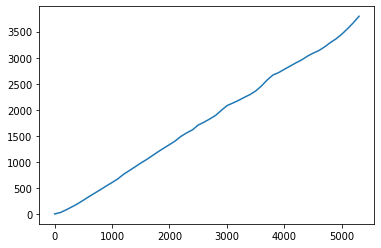

In [32]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [33]:
thres1 = .025
pred = getPred(data_valid, thres1)

In [34]:
acc = metrics.accuracy_score(y_valid, pred)
TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres1)

acc:  0.700962962962963
TN:  3822 FP: 5989 FN:  2085 TP:  15104  |  thres:  0.025


In [39]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'PlayafterBuy or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(data_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('Acc: ', acc, '\tF1: ',f1,\
        '\t\tTN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)


------------------------------PlayafterBuy or NOT------------------------------
Acc:  0.6952592592592592 	F1:  0.7875329236172081 		TN:  3523 FP: 6288 FN:  1940 TP:  15249  |  thres:  0.01
Acc:  0.7007407407407408 	F1:  0.7889788456516061 		TN:  3815 FP: 5996 FN:  2084 TP:  15105  |  thres:  0.05
Acc:  0.6927037037037037 	F1:  0.7846668915937817 		TN:  3586 FP: 6225 FN:  2072 TP:  15117  |  thres:  0.1
Acc:  0.688037037037037 	F1:  0.7828620040731097 		TN:  3393 FP: 6418 FN:  2005 TP:  15184  |  thres:  0.3
Acc:  0.6814444444444444 	F1:  0.7797721162463193 		TN:  3172 FP: 6639 FN:  1962 TP:  15227  |  thres:  0.5
Acc:  0.6768888888888889 	F1:  0.7777438092326506 		TN:  3012 FP: 6799 FN:  1925 TP:  15264  |  thres:  0.7
Acc:  0.675074074074074 	F1:  0.7768422659171266 		TN:  2957 FP: 6854 FN:  1919 TP:  15270  |  thres:  0.9


In [50]:
thres = .05
pred = getPred(data_test, thres)
acc = metrics.accuracy_score(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
f1 = f1_score(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
print('Acc: ', acc, '\tF1: ',f1,\
    '\t\tTN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

Acc:  0.7034 	F1:  0.7904035050526464 		TN:  2883 FP: 4384 FN:  1548 TP:  11185  |  thres:  0.05
